# Problem Statement

Given a set of attributes for an individual, predict whether they qualify for a personal loan and recommend appropriate repayment terms based on their creditworthiness and risk profile. The goal is to assess borrower behavior, financial history, and risk factors to determine whether extending credit is viable, and if so, to propose optimal loan conditions such as repayment duration, interest rate, and loan amount. This decision-making process aims to balance the financial needs of the borrower with the lender's risk management strategy, enhancing both customer satisfaction and business profitability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Exploratory Data Analysis

In [2]:
df=pd.read_csv('data.csv')
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2 years,RENT,40000.0,...,6.0,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5 years,MORTGAGE,110000.0,...,6.0,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10+ years,RENT,56500.0,...,15.0,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,...,9.0,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."


In [3]:
def extract_state(address):
    try:
        # Check if the address contains 'OK' or another state format
        if ',' in address:
            # Extract state from the first address format
            return address.split(',')[1].split(' ')[1].strip()
        else:
            # For the second address format (USCGC Nunez\r\nFPO AE 30723)
            return address.split(' ')[1].strip()
    except IndexError:
        # In case there is any unexpected format, return None or 'Unknown'
        return None

In [4]:
def extract_city(address):
    try:
        # Check if the address contains 'OK' or another state format
        if ',' in address:
            # Extract state from the first address format
            return address.split(',')[0].strip()
        else:
            # For the second address format (USCGC Nunez\r\nFPO AE 30723)
            return address.split(' ')[0].strip()
    except IndexError:
        # In case there is any unexpected format, return None or 'Unknown'
        return None

In [5]:
df['city'] = df.address.str.split(r'\r\n', expand=True)[1].apply(extract_city)
df['state'] = df.address.str.split(r'\r\n', expand=True)[1].apply(extract_state)

In [6]:
df['earliest_cr_line_month']=df.earliest_cr_line.str.split(r'-', expand=True)[0]
df['earliest_cr_line_year']=df.earliest_cr_line.str.split(r'-', expand=True)[1].astype(int)

In [7]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

In [8]:
df['earliest_cr_line_month'] = df['earliest_cr_line_month'].map(month_map)

In [9]:
df = df.drop(columns=['earliest_cr_line', 'address'])

In [10]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,city,state,earliest_cr_line_month,earliest_cr_line_year
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,41.8,25.0,w,INDIVIDUAL,0.0,0.0,Mendozaberg,OK,6,1990
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,53.3,27.0,f,INDIVIDUAL,3.0,0.0,Loganmouth,SD,7,2004
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,92.2,26.0,f,INDIVIDUAL,0.0,0.0,New Sabrina,WV,8,2007
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,21.5,13.0,f,INDIVIDUAL,0.0,0.0,Delacruzside,MA,9,2006
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,69.8,43.0,f,INDIVIDUAL,1.0,0.0,Greggshire,VA,3,1999


## Observations on Data

In [11]:
df.shape

(396030, 29)

There are 396030 rows and 29 columns

#### Column Details:

1. **loan_amnt**: The amount requested by the borrower for the loan.
2. **term**: The loan duration, either 36 or 60 months.
3. **int_rate**: The annual interest rate applied to the loan.
4. **installment**: The fixed monthly repayment amount for the loan.
5. **grade**: LoanTap's assigned loan grade, indicating the risk level (Risk rating by LoanTap).
6. **sub_grade**: A more granular risk rating assigned by LoanTap to the borrower.
7. **emp_title**: The job title of the borrower.
8. **emp_length**: The number of years the borrower has been employed (0-10 years).
9. **home_ownership**: The borrower's housing status (e.g., own, rent, mortgage).
10. **annual_inc**: The borrower’s annual income.
11. **verification_status**: Whether the borrower’s income has been verified.
12. **issue_d**: The date when the loan was issued.
13. **loan_status**: The current status of the loan (e.g., fully paid, charged off).
14. **purpose**: The reason the borrower is requesting the loan.
15. **title**: The title given to the loan by the borrower.
16. **dti (Debt-to-Income ratio)**: The ratio of the borrower’s monthly debt payments to their monthly income.
17. **earliest_cr_line**: The date when the borrower’s oldest credit account was opened.
18. **open_acc**: The number of active credit accounts the borrower has.
19. **pub_rec**: The number of negative records on the borrower’s public credit profile.
20. **revol_bal**: The total balance on the borrower’s revolving credit accounts (e.g., credit cards).
21. **revol_util**: The percentage of available credit used on revolving accounts.
22. **total_acc**: The total number of credit lines the borrower has.
23. **initial_list_status**: The loan’s initial category, either ‘W’ (waiting) or ‘F’ (funded).
24. **application_type**: Whether the application was made individually or jointly with another borrower.
25. **mort_acc**: The number of mortgages the borrower holds.
26. **pub_rec_bankruptcies**: The number of bankruptcy records associated with the borrower.
27. **address**: The location or geographical area of the borrower.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               396030 non-null  float64
 1   term                    396030 non-null  object 
 2   int_rate                396030 non-null  float64
 3   installment             396030 non-null  float64
 4   grade                   396030 non-null  object 
 5   sub_grade               396030 non-null  object 
 6   emp_title               373103 non-null  object 
 7   emp_length              377729 non-null  object 
 8   home_ownership          396030 non-null  object 
 9   annual_inc              396030 non-null  float64
 10  verification_status     396030 non-null  object 
 11  issue_d                 396030 non-null  object 
 12  loan_status             396030 non-null  object 
 13  purpose                 396030 non-null  object 
 14  title               

#### Data Types:
- **Numerical columns:** 12 columns are of type float64, representing financial amounts, rates, and numerical measurements (e.g., loan_amnt, int_rate, installment, etc.).
- **Categorical columns:** 15 columns are of type object, representing categorical variables such as term, grade, emp_title, home_ownership, loan_status, etc. These need to be properly encoded for machine learning tasks.
- **List of Columns with null values:** emp_title, emp_length, title, revol_util, mort_acc, pub_rec_bankruptcies

In [13]:
print('Statiscal description of categorical columns')
df.describe(include=['object'])

Statiscal description of categorical columns


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,application_type,city,state
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394274,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48816,2,3,67513,54
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,f,INDIVIDUAL,DPO,AP
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,238066,395319,14289,14308


#### Statistical Summary (Categorical Columns):
- **loan_status:** The most frequent loan status is "Fully Paid", with a frequency of 318,357, indicating that the majority of the loans in the dataset have been paid off.
- **home_ownership:** Most borrowers own homes, with MORTGAGE being the most frequent value (198,348 occurrences).
- **purpose:** The most frequent loan purpose is debt_consolidation, showing that a significant number of loans are for consolidating existing debt.
- **emp_title:** A diverse range of job titles, but with many missing values, suggesting that many records do not specify the job title of the borrower.
- **emp_length:** The majority of borrowers have 10+ years of employment history, but some records have missing or unspecified employment lengths.
- **issue_d:** The most frequent issue date is October 2014, indicating that the dataset spans multiple loan issue dates, with 115 unique dates.
- **city:** The most frequent city is DPO, appearing 14,289 times. The dataset covers a wide range of locations with 67,513 unique cities.
- **state:** The most frequent state is AP, appearing 14,308 times. The dataset includes loans from 54 unique states, showing broad geographical distribution.
- **term:** The most frequent term is 36 months, appearing 302,005 times. There are 2 unique terms in the dataset.
- **grade:** The most frequent grade is B, appearing 116,018 times. There are 7 unique grades.
- **sub_grade:** The most frequent sub-grade is B3, appearing 26,655 times. There are 35 unique sub-grades.
- **verification_status:** The most frequent verification status is Verified, appearing 139,563 times. There are 3 unique verification statuses.
- **title:** The most frequent loan title is Debt consolidation, appearing 152,472 times. There are 48,816 unique titles, with some missing values (1,756 rows).
- **initial_list_status:** The most frequent initial list status is f, appearing 238,066 times. There are 2 unique statuses.
- **application_type:** The most frequent application type is INDIVIDUAL, appearing 395,319 times. There are 3 unique application types.

In [14]:
print('Statiscal description of numerical columns')
df.describe()

Statiscal description of numerical columns


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,earliest_cr_line_month,earliest_cr_line_year
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000,396030.000000,396030.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648,6.756231,1997.857667
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174,3.435011,7.198387
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,1.000000,1944.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000,4.000000,1994.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000,7.000000,1999.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000,10.000000,2003.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000,12.000000,2013.000000


#### Statistical Summary (Numerical Columns):
- **Loan Amount (loan_amnt):** The average loan amount is approximately 14,114, with a range between 500 and 40,000. This suggests that most loans are relatively smaller (around 8,000 - 12,000), with a few large loans driving the upper bound.
- **Interest Rate (int_rate):** The mean interest rate is 13.64%, with a standard deviation of 4.47%. This implies a somewhat uniform interest rate distribution with some outliers.
- **Installment (installment):** The average installment is 431.85, with a high standard deviation (250.73). This suggests that installment amounts can vary significantly depending on the loan amount.
- **Annual Income (annual_inc):** The average annual income is about 74,203, with a high standard deviation (61,637), indicating a large income disparity in the dataset.
- **Debt-to-Income Ratio (dti):** The average dti is 17.38, indicating a moderate level of debt compared to income on average.
- **open_acc (Open Accounts):** Average number of open accounts: 11.31. Range: 0 to 90. The majority have between 8 (25th percentile) and 14 (75th percentile) open accounts.
- **pub_rec (Public Records):** Average number of public records: 0.18. Range: 0 to 86. Most borrowers have 0 public records.
- **Revolving Balance (revol_bal):** The mean revolving balance is around 15,844, which seems reasonable given the range of credit balances.
- **Revolving Utilization (revol_util):** The mean is 53.79, showing that on average, individuals are using more than half of their available credit, with a std deviation of 24.45 suggesting high variation.
- **total_acc (Total Accounts):** Average total accounts: 25.41. Range: 2 to 151. Typically, borrowers have between 17 (25th percentile) and 32 (75th percentile) total accounts.
- **Mortgage Accounts (mort_acc):** The mort_acc column has a mean of 1.81 but also significant missing data (9.54%). It might be worth investigating how it impacts the dataset and whether imputation or dropping is better.
- **pub_rec_bankruptcies:** Average bankruptcies: 0.12. Range: 0 to 8. Most borrowers have 0 bankruptcies.
- **earliest_cr_line_month:** Average month: June (6.76). Range: January (1) to December (12).
- **earliest_cr_line_year:** Average year: 1997.86. Range: 1944 to 2013. The 25th percentile year is 1994, and the 75th percentile is 2003.

## Univariate Analysis

Column name: term and it contains 
 term
36 months    302005
60 months     94025
Name: count, dtype: int64


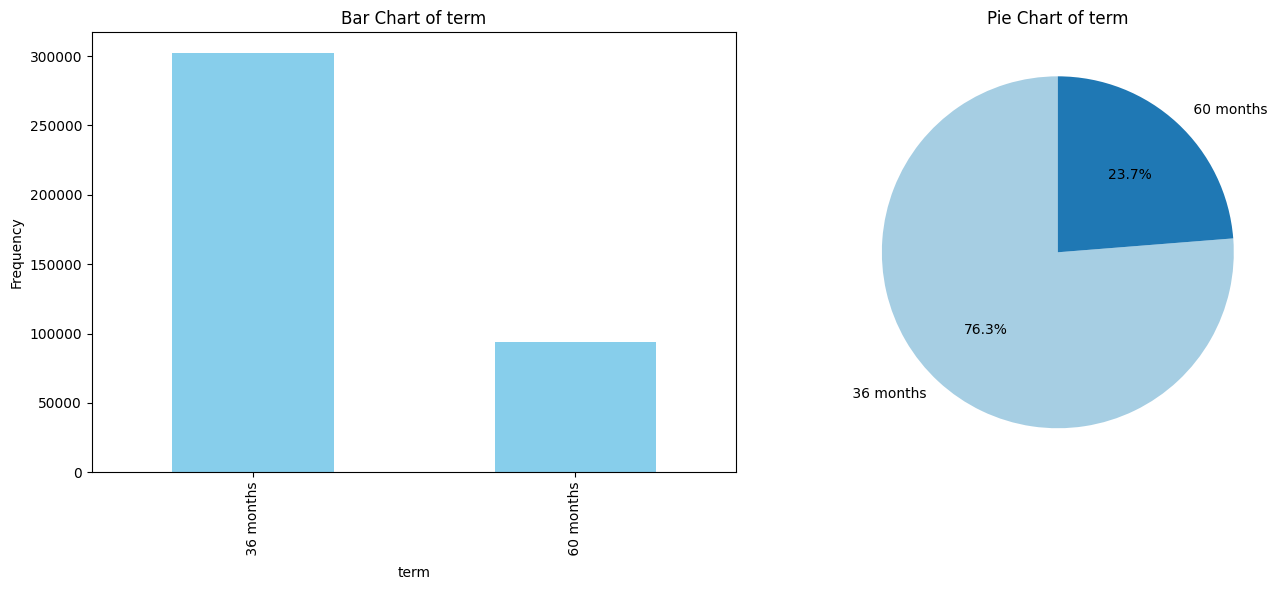

Column name: grade and it contains 
 grade
B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: count, dtype: int64


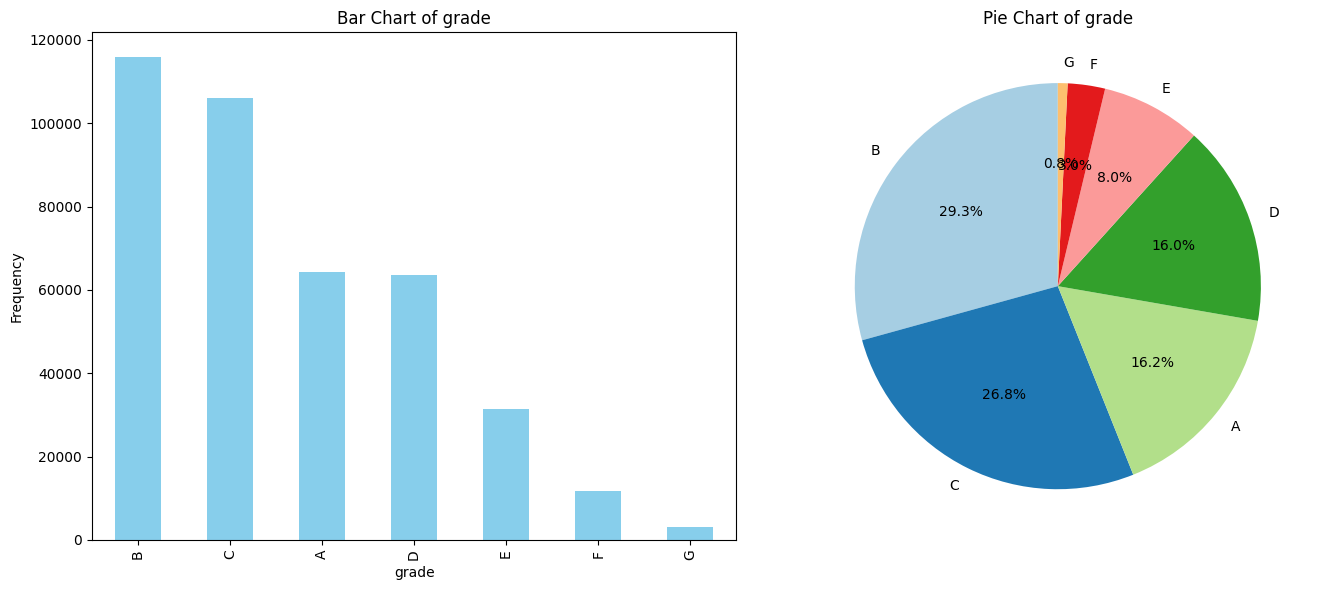

Column name: sub_grade and it contains 
 sub_grade
B3    26655
B4    25601
C1    23662
C2    22580
B2    22495
B5    22085
C3    21221
C4    20280
B1    19182
A5    18526
C5    18244
D1    15993
A4    15789
D2    13951
D3    12223
D4    11657
A3    10576
A1     9729
D5     9700
A2     9567
E1     7917
E2     7431
E3     6207
E4     5361
E5     4572
F1     3536
F2     2766
F3     2286
F4     1787
F5     1397
G1     1058
G2      754
G3      552
G4      374
G5      316
Name: count, dtype: int64


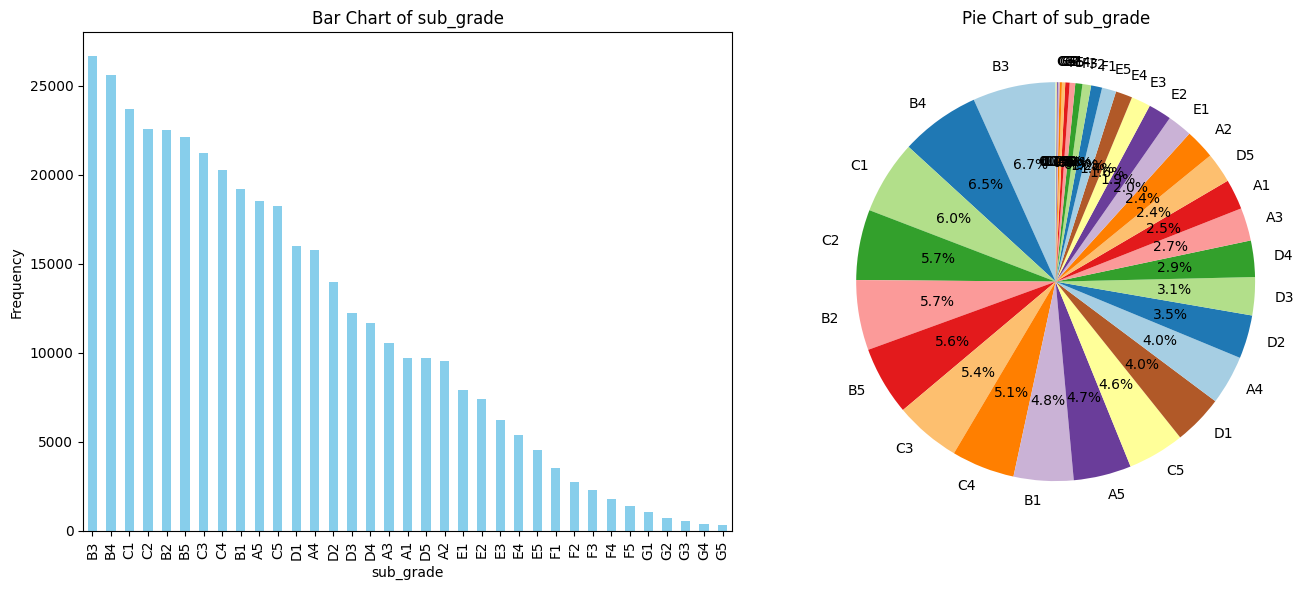

Column name: emp_title and it contains 
 emp_title
Teacher                         4389
Manager                         4250
Registered Nurse                1856
RN                              1846
Supervisor                      1830
                                ... 
Social Work/Care Manager           1
Regional Counsel                   1
Nor-Com Inc                        1
Director of the Bach Society       1
SPO II                             1
Name: count, Length: 173105, dtype: int64
Too many values to plot bar and pie chart for column 'emp_title' 


Column name: emp_length and it contains 
 emp_length
10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: count, dtype: int64


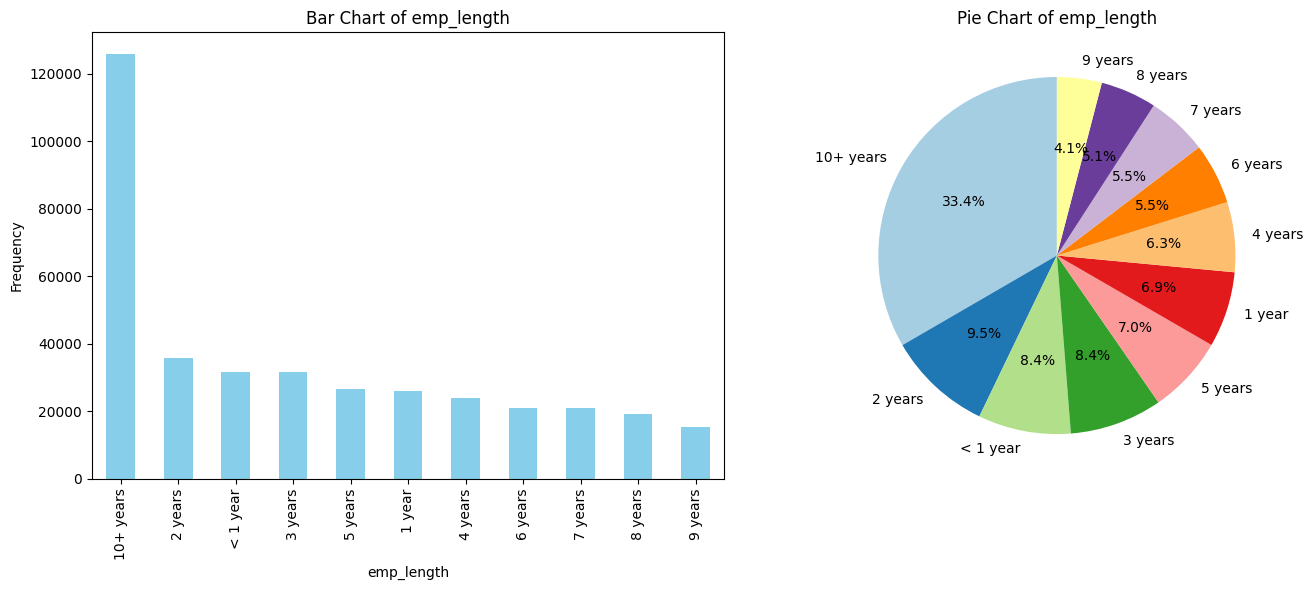

Column name: home_ownership and it contains 
 home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64


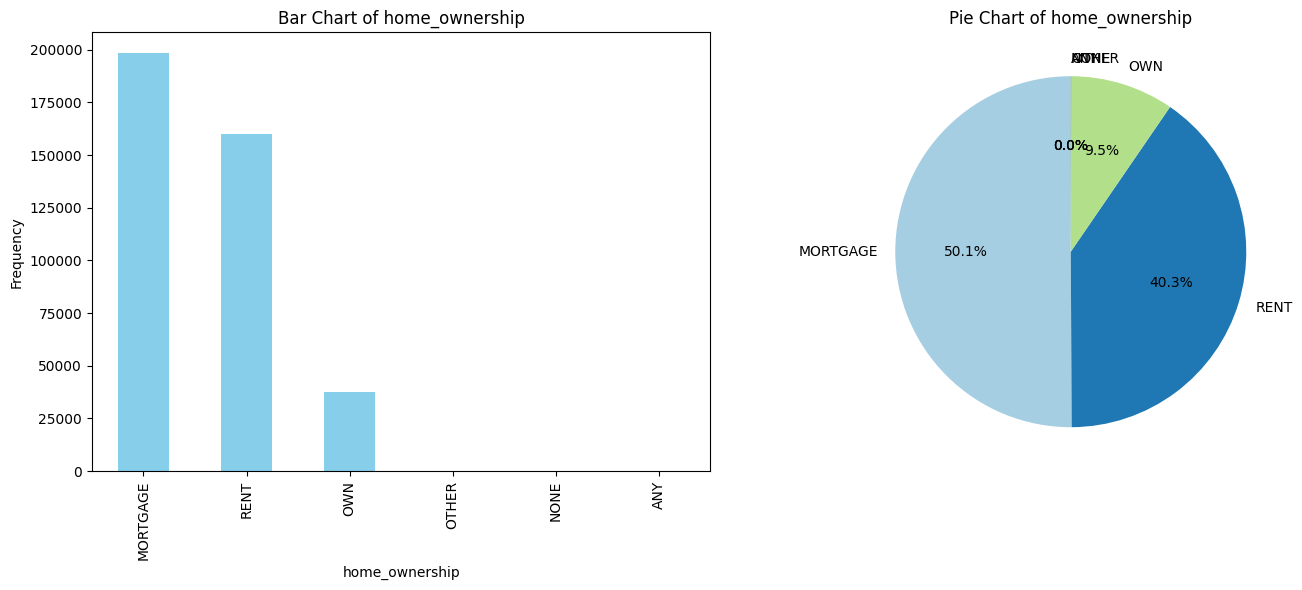

Column name: verification_status and it contains 
 verification_status
Verified           139563
Source Verified    131385
Not Verified       125082
Name: count, dtype: int64


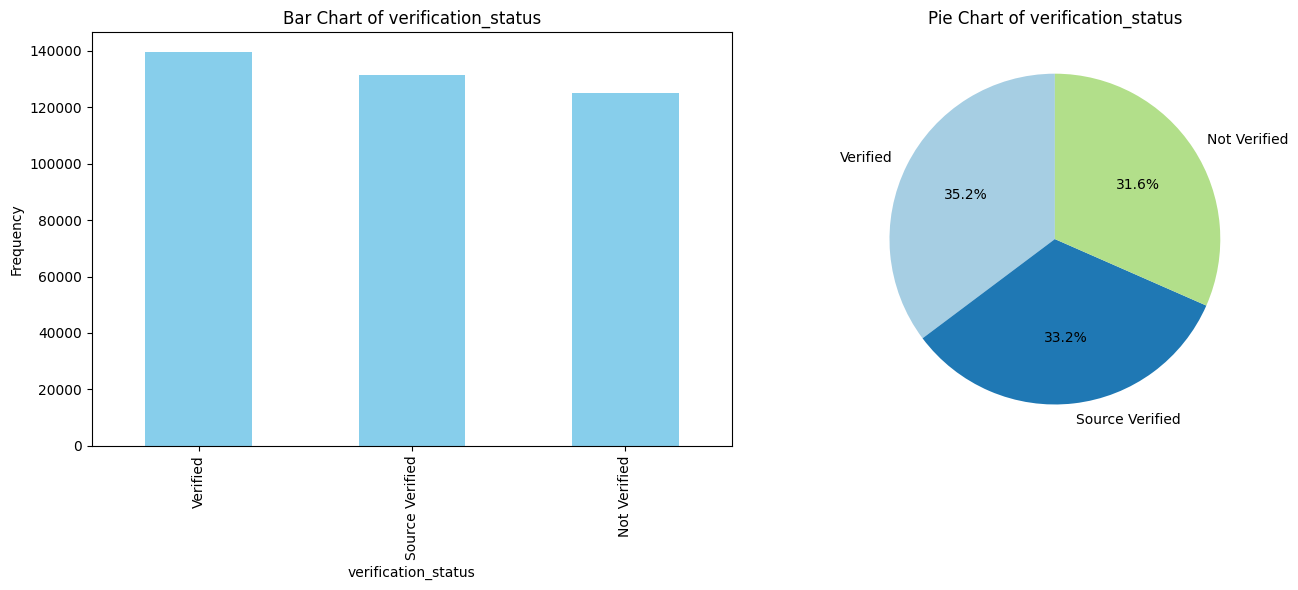

Column name: issue_d and it contains 
 issue_d
Oct-2014    14846
Jul-2014    12609
Jan-2015    11705
Dec-2013    10618
Nov-2013    10496
            ...  
Aug-2007       26
Sep-2008       25
Nov-2007       22
Sep-2007       15
Jun-2007        1
Name: count, Length: 115, dtype: int64
Too many values to plot bar and pie chart for column 'issue_d' 


Column name: loan_status and it contains 
 loan_status
Fully Paid     318357
Charged Off     77673
Name: count, dtype: int64


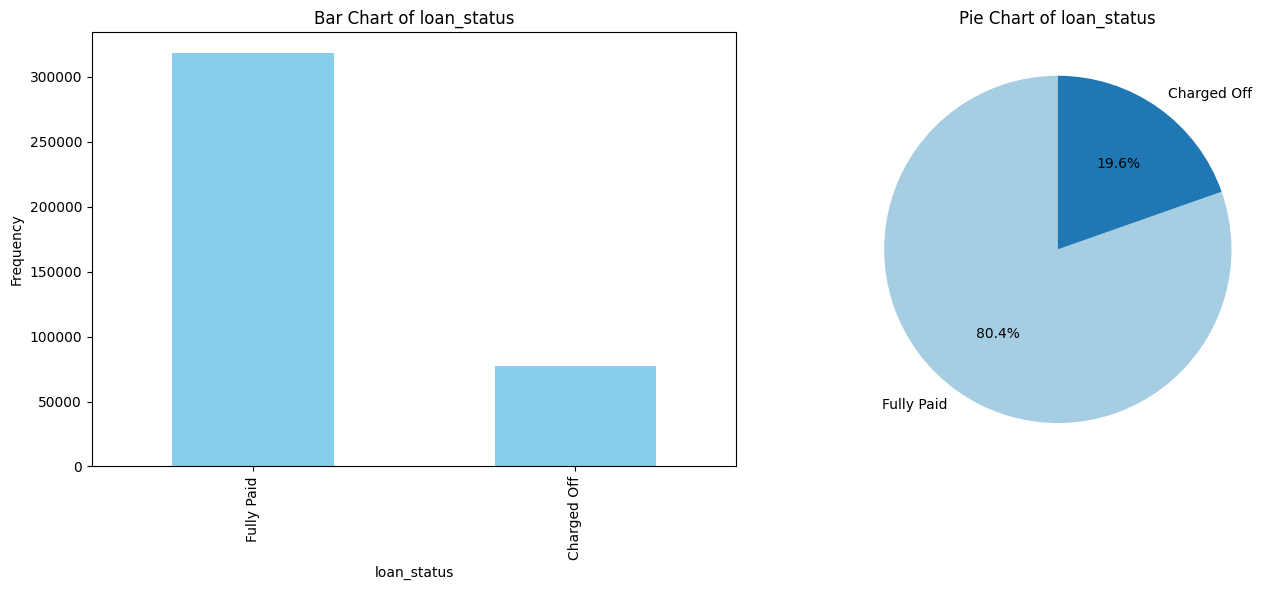

Column name: purpose and it contains 
 purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: count, dtype: int64


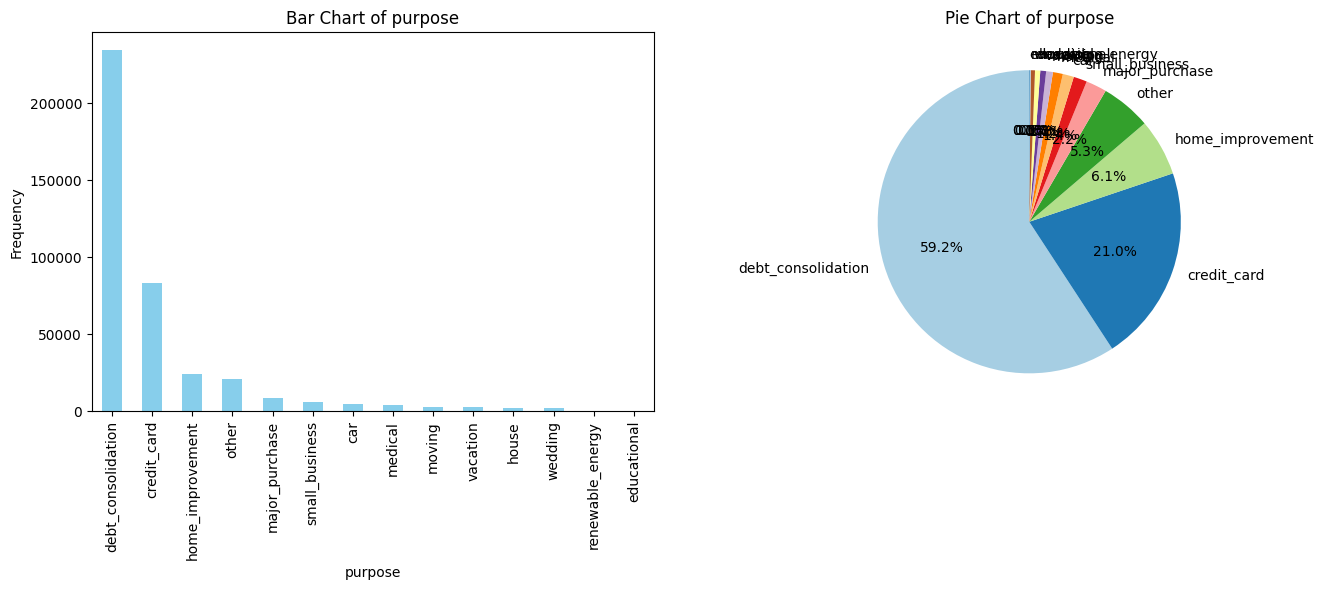

Column name: title and it contains 
 title
Debt consolidation                       152472
Credit card refinancing                   51487
Home improvement                          15264
Other                                     12930
Debt Consolidation                        11608
                                          ...  
Outboard Motor Repower Loan                   1
2011 Insurance and Debt Consolidation         1
Credit buster                                 1
Loanforpayoff                                 1
Toxic Debt Payoff                             1
Name: count, Length: 48816, dtype: int64
Too many values to plot bar and pie chart for column 'title' 


Column name: initial_list_status and it contains 
 initial_list_status
f    238066
w    157964
Name: count, dtype: int64


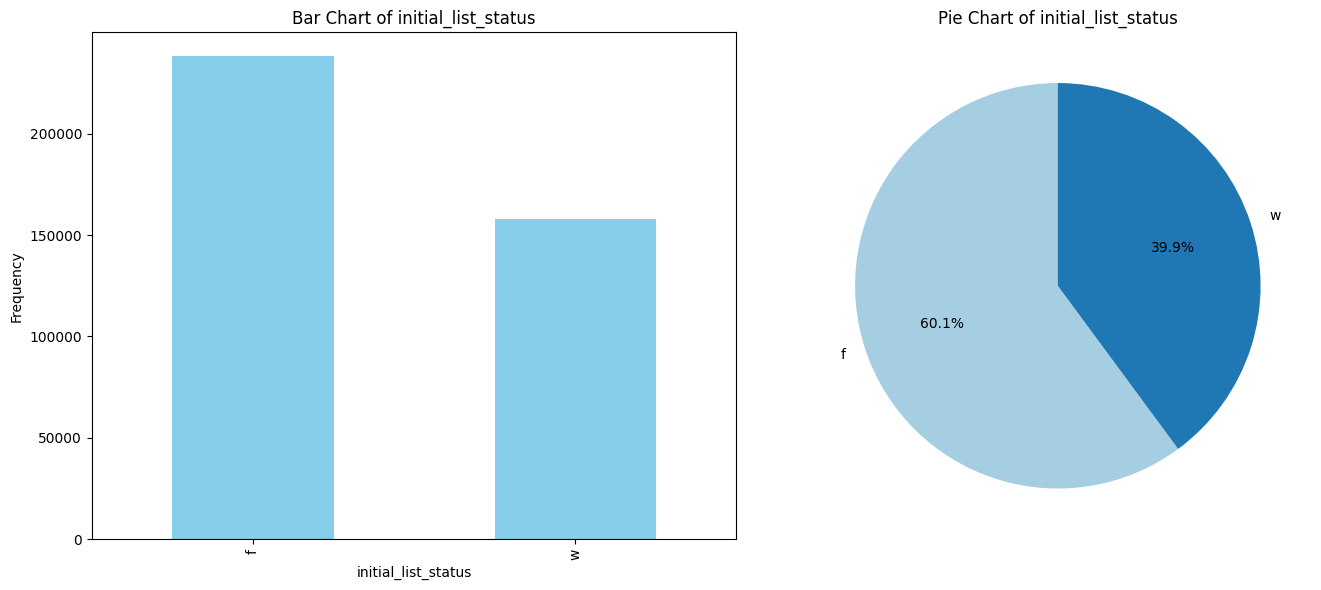

Column name: application_type and it contains 
 application_type
INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: count, dtype: int64


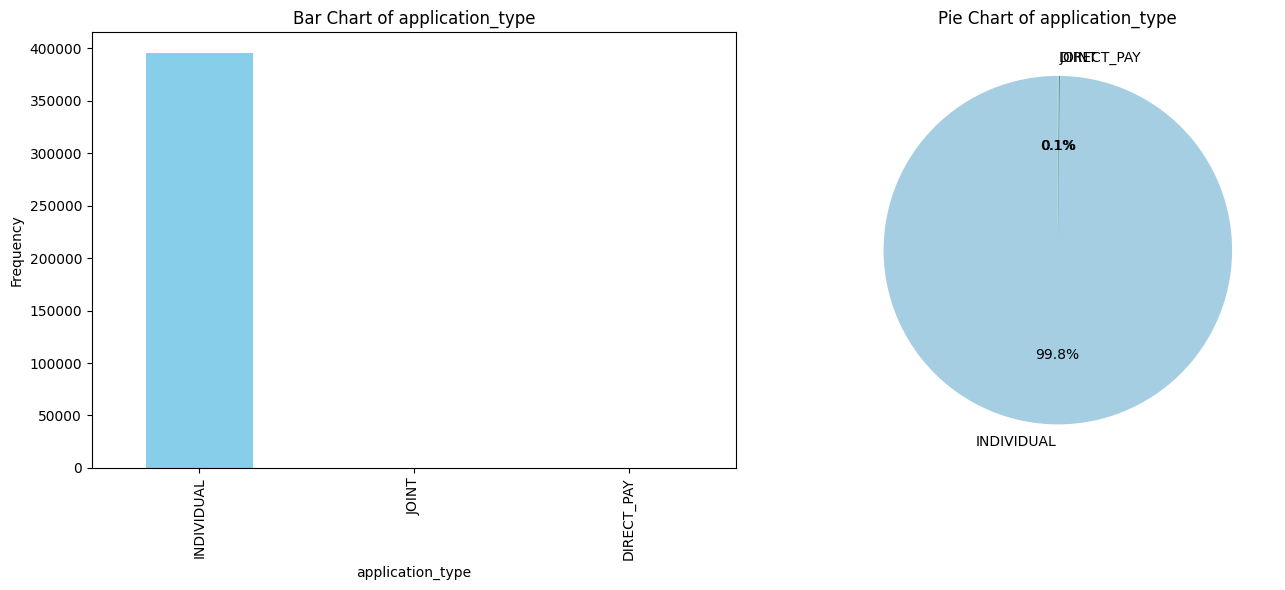

Column name: city and it contains 
 city
DPO                     14289
APO                     14060
FPO                     14035
East Michael              311
Port Michael              305
                        ...  
South Noahshire             1
Lake Jeremyfurt             1
East Dillonfurt             1
North Nicolasville          1
South Natashaborough        1
Name: count, Length: 67513, dtype: int64
Too many values to plot bar and pie chart for column 'city' 


Column name: state and it contains 
 state
AP    14308
AE    14157
AA    13919
NJ     7091
WI     7081
LA     7068
NV     7038
AK     7034
MA     7022
VA     7022
VT     7005
NY     7004
MS     7003
TX     7000
SC     6973
ME     6972
AR     6969
OH     6969
GA     6967
IN     6958
ID     6958
KS     6945
WV     6944
RI     6940
MO     6939
IL     6934
WY     6933
HI     6927
NE     6927
IA     6926
FL     6921
AZ     6918
CO     6914
OK     6911
MN     6904
CT     6904
NC     6901
OR     6898
CA     6898
AL     6898
MD

In [15]:
for i in df.select_dtypes(include=['object']).columns.tolist():
    print(f'Column name: {i} and it contains \n {df[i].value_counts()}')
    if len(df[i].value_counts()) > 50:
        print(f"\033[1mToo many values to plot bar and pie chart for column '{i}'\033[0m \n\n")
        continue
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df[i].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Bar Chart of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    pie_data = df[i].value_counts()
    axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'Pie Chart of {i}')
    plt.tight_layout()
    plt.show()

#### Analysis and Insights (Categorical Columns)
- **Term:**
    - The majority of loans have a term of 36 months (about 76%) compared to 60 months (around 24%).
    - Insight: Most borrowers prefer shorter-term loans, possibly due to quicker repayment cycles. This could indicate a more financially stable borrower group.
- **Grade:**
    - The most common grades are B (29%) and C (27%), followed by A (16%) and D (16%).
    - Insight: The grade distribution shows that the loans are largely concentrated in the middle-range credit grades. This suggests that most borrowers are not in the highest or lowest risk categories.
- **Sub-Grade:**
    - The sub-grades B3, B4, and C1 are the most frequent, with B3 being the highest.
    - Insight: Sub-grades are more granular, and this distribution shows a heavy skew toward B and C grades. Loans for these sub-grades likely represent moderate-risk borrowers.
- **Employment Title:**
    - There is a wide range of unique job titles (173,105 in total), with "Teacher", "Manager", "Registered Nurse", and "Supervisor" being the most frequent.
    - Insight: The variety in employment titles suggests a diverse borrower base. Certain job titles, like "Teacher" and "Manager", could represent stable income sources, which may correlate with loan repayment ability.
- **Employment Length:**
    - The majority of borrowers have 10+ years of employment (about 31%), followed by 2 years (9%), and < 1 year (8%).
    - Insight: Most borrowers have a relatively long and stable employment history, which is a positive indicator of financial stability and the ability to repay loans.
- **Home Ownership:**
    - The majority of borrowers have a mortgage (50%), followed by renters (40%), and a smaller percentage of owners (9%).
    - Insight: A large number of borrowers have mortgages, which might suggest that many of them have some level of financial stability but are also leveraging credit for additional financial needs.
- **Verification Status:**
    - The majority of borrowers are "Verified" (35%), followed by "Source Verified" (33%) and "Not Verified" (32%).
    - Insight: A large proportion of borrowers have verified income or other details, suggesting that the dataset may represent a relatively trustworthy sample of applicants.
- **Issue Date:**
    - The issue dates are spread across multiple years, with Oct 2014 being the most common issue month (approximately 3.75% of the data).
    - Insight: The dataset covers a broad range of loan periods, which could provide valuable insights into trends over time, such as changes in loan types, amounts, and interest rates.
- **Loan Status:**
    - Most loans have been "Fully Paid" (80%), while a smaller percentage are "Charged Off" (20%).
    - Insight: The high percentage of fully paid loans suggests that the dataset could primarily consist of borrowers who successfully repaid their loans, which could positively skew risk assessments.
- **Purpose:**
    - The majority of loans are taken for debt consolidation (59%), followed by credit card refinancing (21%).
    - Insight: Debt consolidation is a major reason for taking out loans, indicating that many borrowers may be trying to simplify their finances by consolidating multiple debts into one.
- **Title:**
    - Titles like "Debt Consolidation" and "Credit Card Refinancing" are the most common, reflecting the purposes of the loans.
    - Insight: The similarity in loan titles and purposes (such as debt consolidation) further confirms the idea that borrowers are using these loans to manage or restructure their debts.
- **Initial List Status:**
    - The majority of loans were listed as "f" (fully funded), followed by "w" (waiting for funding).
    - Insight: The preponderance of fully funded loans (80%) indicates that most loans in the dataset were successfully issued.
- **Application Type:**
    - Most applicants applied as "INDIVIDUAL" (99%), with a very small percentage applying as "JOINT" or "DIRECT_PAY".
    - Insight: The high percentage of individual applicants may indicate that personal loans are more common than joint loans in this dataset.
- **City:**
    - The city column has 67,513 unique values, with DPO (14,289), APO (14,060), and FPO (14,035) dominating, indicating a high number of military or government addresses. The distribution is skewed, with most cities appearing only once or a few times.
- **State:**
    - The state column has 54 unique values, with AP (14,308), AE (14,157), and AA (13,919) being the most frequent, indicating a significant number of military or diplomatic addresses. The distribution shows other states appearing in smaller, relatively even proportions.


--------------------------------------------------
Analysis for Column: loan_amnt
--------------------------------------------------
Skewness: 0.7773
Kurtosis: -0.0626

Top 10 value counts:
loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
8000.0     13539
6000.0     12734
5000.0     12443
16000.0    10129
18000.0     9195
Name: count, dtype: int64

Bottom 10 value counts:
loan_amnt
36525.0    1
36625.0    1
38825.0    1
30050.0    1
39475.0    1
39200.0    1
38750.0    1
36275.0    1
36475.0    1
725.0      1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.492243
1   -0.731551
2    0.177819
3   -0.827274
4    1.227783
5    0.704297
6    0.464989
7   -0.133281
8    0.572677
9    1.458117
Name: loan_amnt, dtype: float64


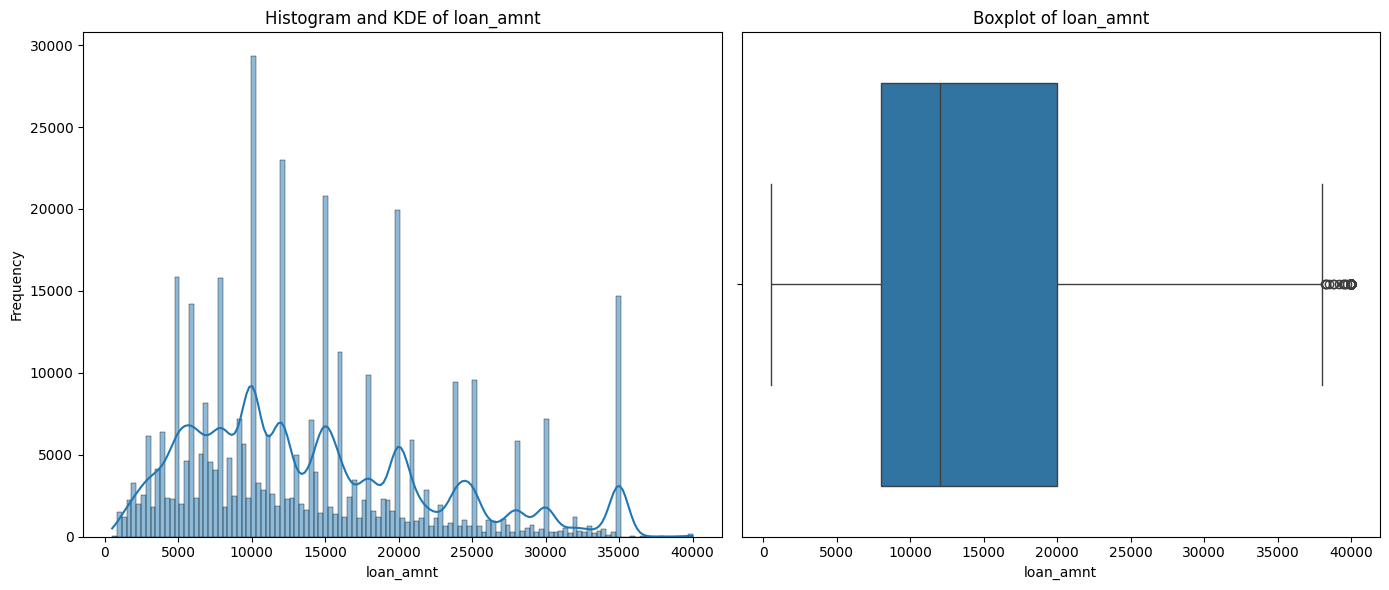


--------------------------------------------------
Analysis for Column: int_rate
--------------------------------------------------
Skewness: 0.4207
Kurtosis: -0.1439

Top 10 value counts:
int_rate
10.99    12411
12.99     9632
15.61     9350
11.99     8582
8.90      8019
12.12     7358
7.90      7332
16.29     6632
13.11     6580
6.03      6291
Name: count, dtype: int64

Bottom 10 value counts:
int_rate
14.70    1
17.34    1
16.15    1
18.72    1
18.36    1
14.38    1
24.40    1
22.64    1
17.54    1
17.44    1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.491799
1   -0.368816
2   -0.704225
3   -1.598649
4    0.811824
5   -0.069184
6   -1.860268
7   -0.558881
8   -0.592422
9    0.592690
Name: int_rate, dtype: float64


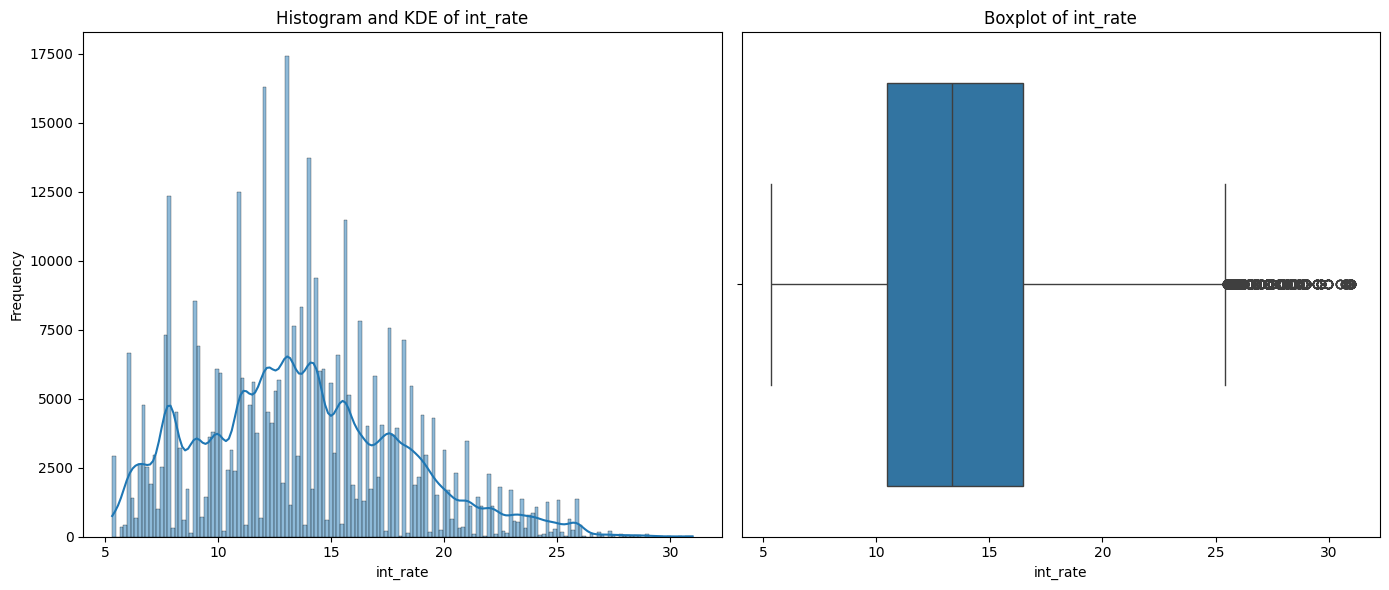


--------------------------------------------------
Analysis for Column: installment
--------------------------------------------------
Skewness: 0.9836
Kurtosis: 0.7838

Top 10 value counts:
installment
327.34    968
332.10    791
491.01    736
336.90    686
392.81    683
332.72    641
337.47    624
317.54    574
654.68    556
261.88    527
Name: count, dtype: int64

Bottom 10 value counts:
installment
144.05     1
430.13     1
301.13     1
281.69     1
395.90     1
1146.14    1
218.49     1
961.66     1
569.10     1
555.96     1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.408291
1   -0.662750
2    0.299609
3   -0.842348
4    0.707861
5    0.978035
6    0.439602
7   -0.021456
8   -0.083795
9    1.980438
Name: installment, dtype: float64


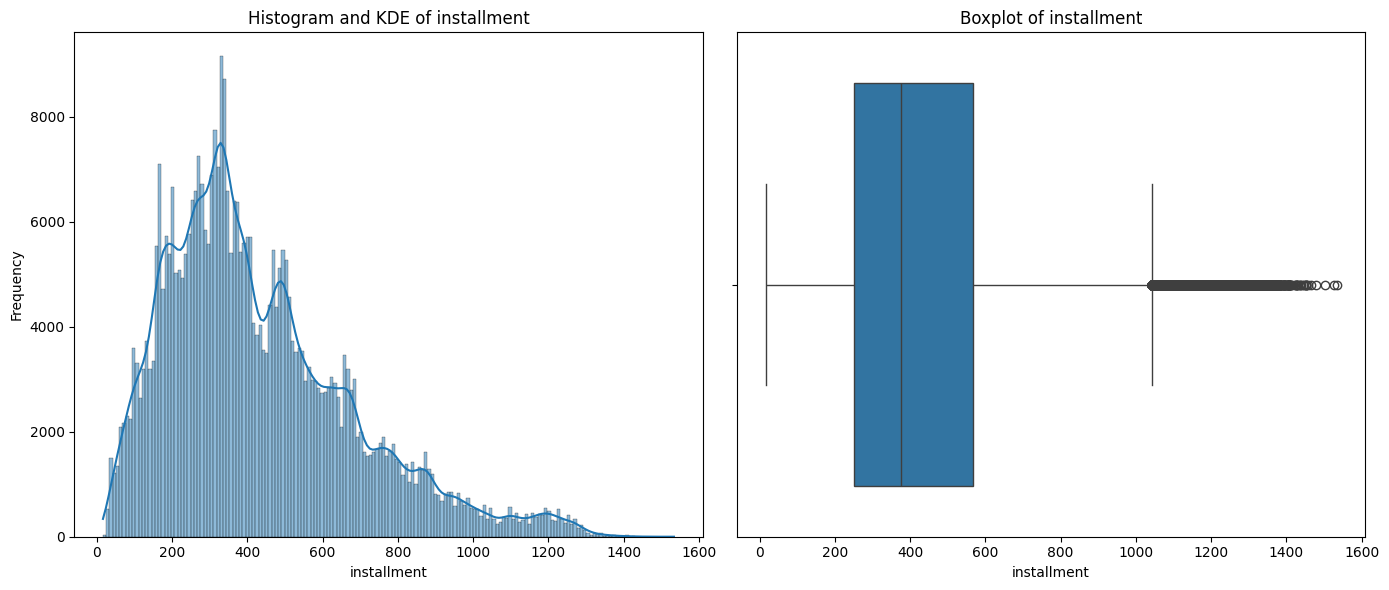


--------------------------------------------------
Analysis for Column: annual_inc
--------------------------------------------------
Skewness: 41.0427
Kurtosis: 4238.5506

Top 10 value counts:
annual_inc
60000.0    15313
50000.0    13303
65000.0    11333
70000.0    10674
40000.0    10629
45000.0    10114
80000.0     9971
75000.0     9850
55000.0     9195
90000.0     7573
Name: count, dtype: int64

Bottom 10 value counts:
annual_inc
68455.0     1
745000.0    1
341120.0    1
63908.0     1
49043.0     1
42558.0     1
29899.0     1
25837.2     1
128647.0    1
23085.0     1
Name: count, dtype: int64

Z-scores (First 10 values):
0    0.694330
1   -0.149311
2   -0.505312
3   -0.327774
4   -0.311550
5    0.204175
6    0.824121
7   -0.457565
8    0.467196
9    0.661883
Name: annual_inc, dtype: float64


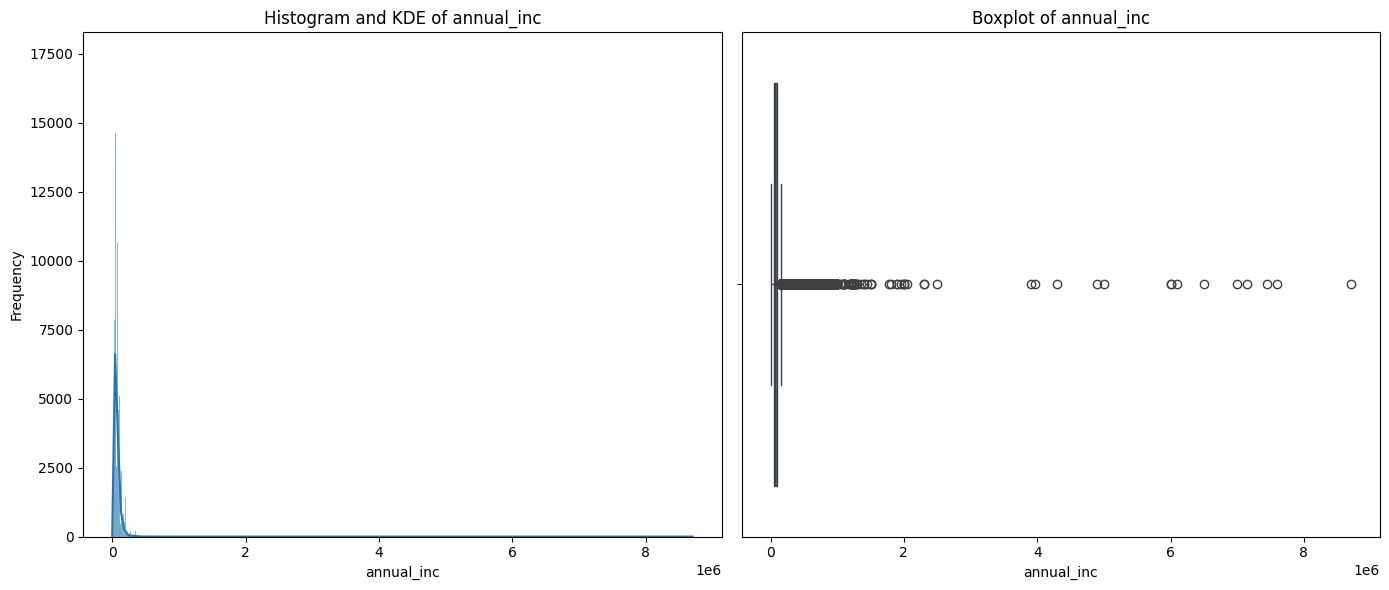


--------------------------------------------------
Analysis for Column: dti
--------------------------------------------------
Skewness: 431.0512
Kurtosis: 237923.6765

Top 10 value counts:
dti
0.0     313
14.4    310
19.2    302
16.8    301
18.0    300
20.4    296
12.0    293
13.2    291
21.6    270
15.6    266
Name: count, dtype: int64

Bottom 10 value counts:
dti
45.15    1
42.30    1
54.90    1
45.72    1
68.30    1
41.38    1
49.83    1
46.32    1
43.98    1
40.61    1
Name: count, dtype: int64

Z-scores (First 10 values):
0    0.491728
1    0.259197
2   -0.254703
3   -0.820215
4    0.919608
5   -0.059355
6   -0.889031
7    0.526691
8   -0.269687
9    0.350212
Name: dti, dtype: float64


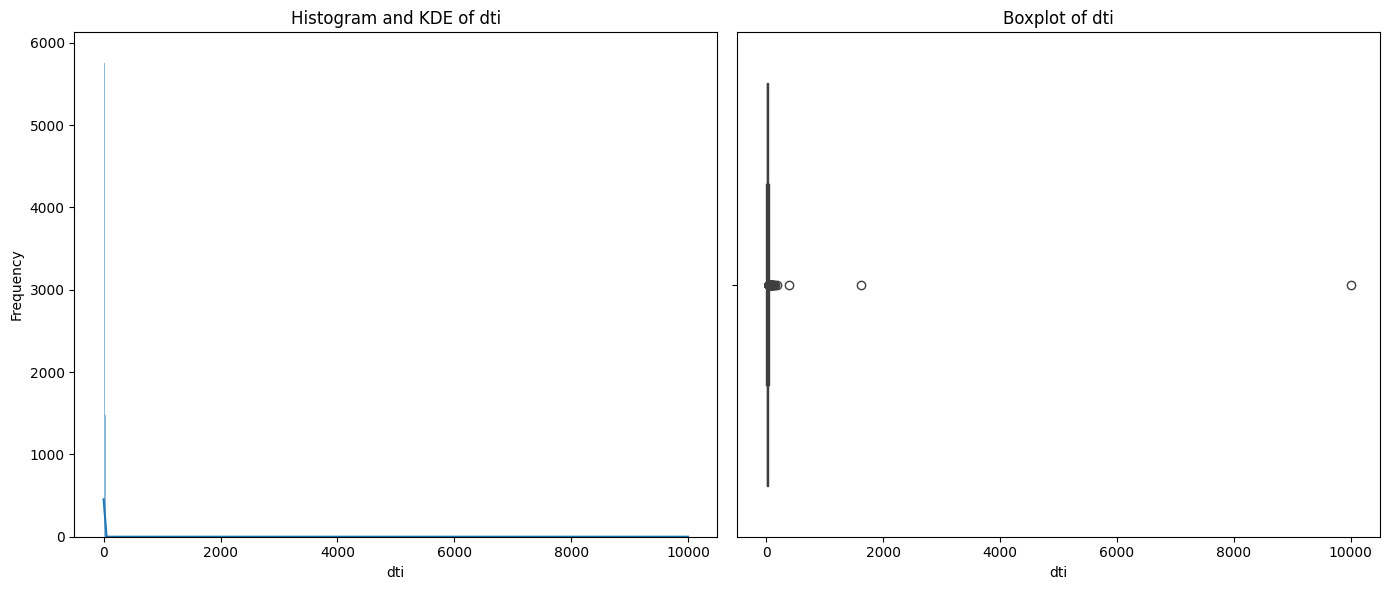


--------------------------------------------------
Analysis for Column: open_acc
--------------------------------------------------
Skewness: 1.2130
Kurtosis: 2.9669

Top 10 value counts:
open_acc
9.0     36779
10.0    35441
8.0     35137
11.0    32695
7.0     31328
12.0    29157
6.0     25927
13.0    24983
14.0    21173
5.0     18308
Name: count, dtype: int64

Bottom 10 value counts:
open_acc
50.0    6
51.0    4
54.0    3
52.0    3
76.0    2
56.0    2
55.0    2
57.0    1
58.0    1
90.0    1
Name: count, dtype: int64

Z-scores (First 10 values):
0    0.912646
1    1.107287
2    0.328720
3   -1.033772
4    0.328720
5   -0.644489
6   -0.644489
7   -0.060563
8    0.328720
9    0.328720
Name: open_acc, dtype: float64


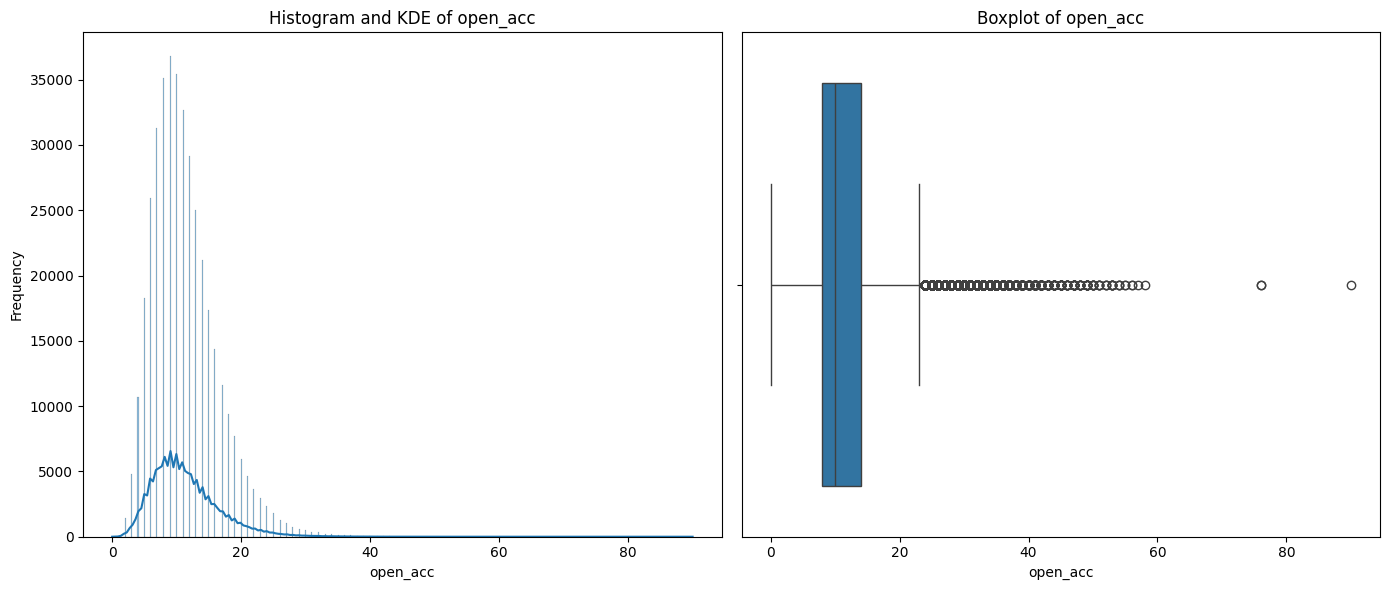


--------------------------------------------------
Analysis for Column: pub_rec
--------------------------------------------------
Skewness: 16.5766
Kurtosis: 1867.4666

Top 10 value counts:
pub_rec
0.0    338272
1.0     49739
2.0      5476
3.0      1521
4.0       527
5.0       237
6.0       122
7.0        56
8.0        34
9.0        12
Name: count, dtype: int64

Bottom 10 value counts:
pub_rec
10.0    11
11.0     8
13.0     4
12.0     4
19.0     2
40.0     1
17.0     1
86.0     1
24.0     1
15.0     1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.335785
1   -0.335785
2   -0.335785
3   -0.335785
4   -0.335785
5   -0.335785
6   -0.335785
7   -0.335785
8   -0.335785
9   -0.335785
Name: pub_rec, dtype: float64


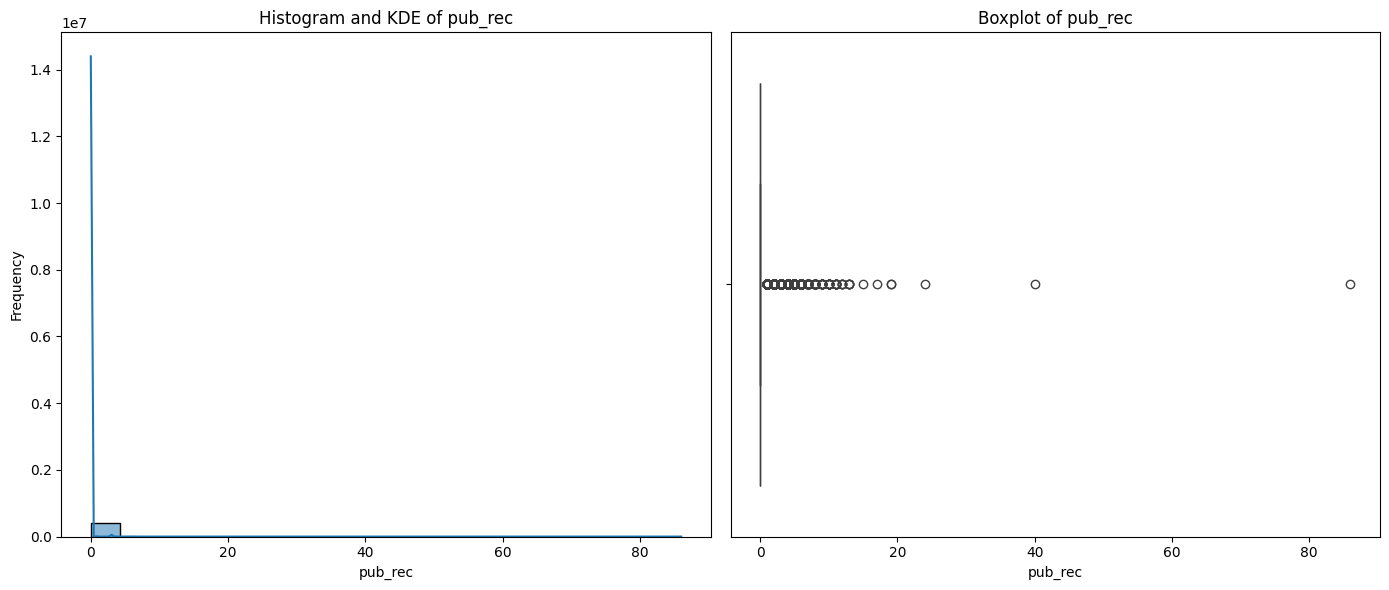


--------------------------------------------------
Analysis for Column: revol_bal
--------------------------------------------------
Skewness: 11.7275
Kurtosis: 384.2211

Top 10 value counts:
revol_bal
0.0       2128
5655.0      41
7792.0      38
6095.0      38
3953.0      37
5098.0      36
6077.0      36
8502.0      35
6521.0      35
5235.0      35
Name: count, dtype: int64

Bottom 10 value counts:
revol_bal
321205.0    1
52972.0     1
25021.0     1
73328.0     1
40296.0     1
147559.0    1
50316.0     1
222641.0    1
568659.0    1
57725.0     1
Name: count, dtype: int64

Z-scores (First 10 values):
0    0.996729
1    0.208163
2   -0.187334
3   -0.503722
4    0.424414
5    0.481379
6   -0.566562
7   -0.117500
8    0.135610
9    0.307232
Name: revol_bal, dtype: float64


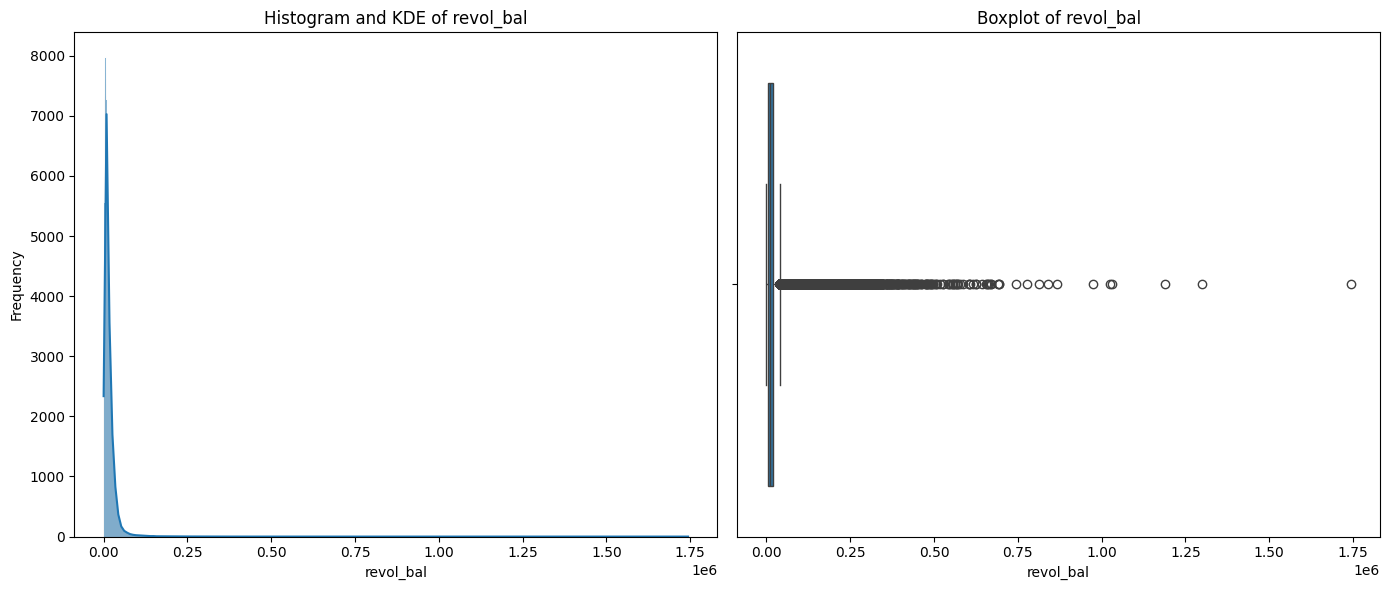


--------------------------------------------------
Analysis for Column: revol_util
--------------------------------------------------
Skewness: -0.0718
Kurtosis: 2.7123

Top 10 value counts:
revol_util
0.0     2213
53.0     752
60.0     739
61.0     734
55.0     730
54.0     725
62.0     721
47.0     720
57.0     719
58.0     717
Name: count, dtype: int64

Bottom 10 value counts:
revol_util
10.61     1
129.50    1
108.60    1
111.10    1
0.75      1
146.10    1
109.30    1
108.10    1
115.30    1
37.63     1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.490417
1   -0.020111
2    1.570751
3   -1.320609
4    0.654676
5    1.914279
6   -1.999486
7    0.437927
8   -0.854393
9    1.169968
Name: revol_util, dtype: float64


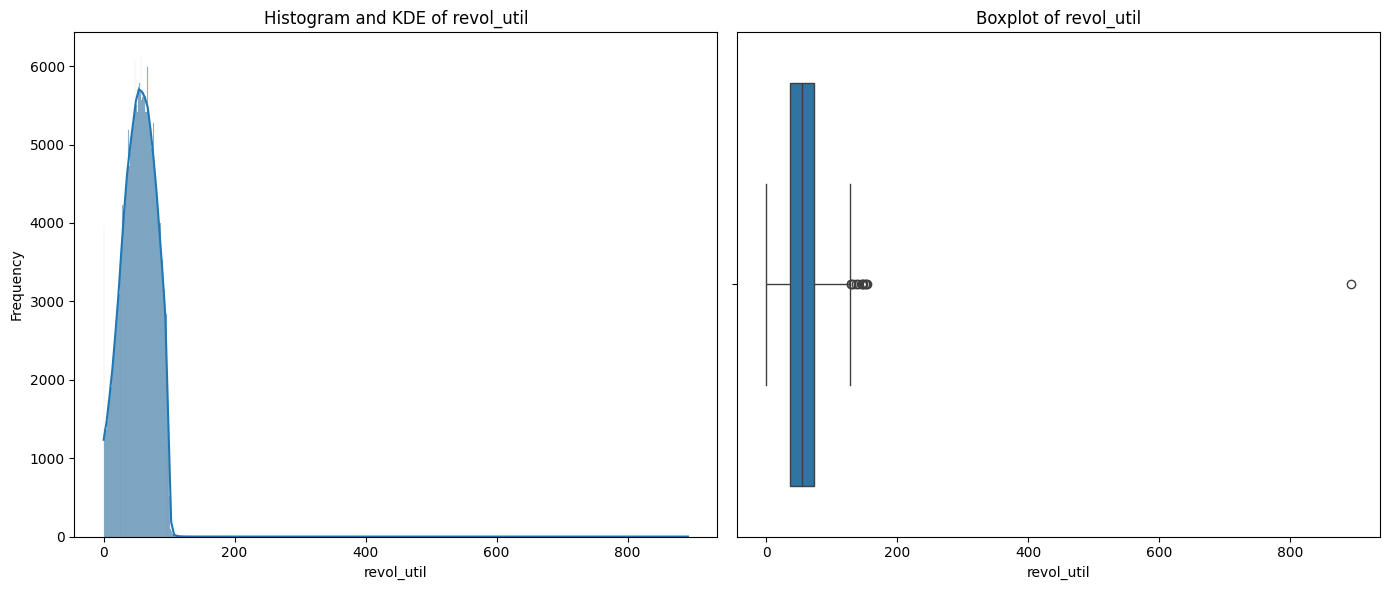


--------------------------------------------------
Analysis for Column: total_acc
--------------------------------------------------
Skewness: 0.8643
Kurtosis: 1.2046

Top 10 value counts:
total_acc
21.0    14280
22.0    14260
20.0    14228
23.0    13923
24.0    13878
19.0    13876
18.0    13710
17.0    13495
25.0    13225
26.0    12799
Name: count, dtype: int64

Bottom 10 value counts:
total_acc
110.0    1
129.0    1
118.0    1
151.0    1
124.0    1
150.0    1
117.0    1
115.0    1
100.0    1
103.0    1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.034891
1    0.133361
2    0.049235
3   -1.044399
4    1.479372
5   -0.203142
6   -0.034891
7   -0.876147
8    1.226995
9    0.974618
Name: total_acc, dtype: float64


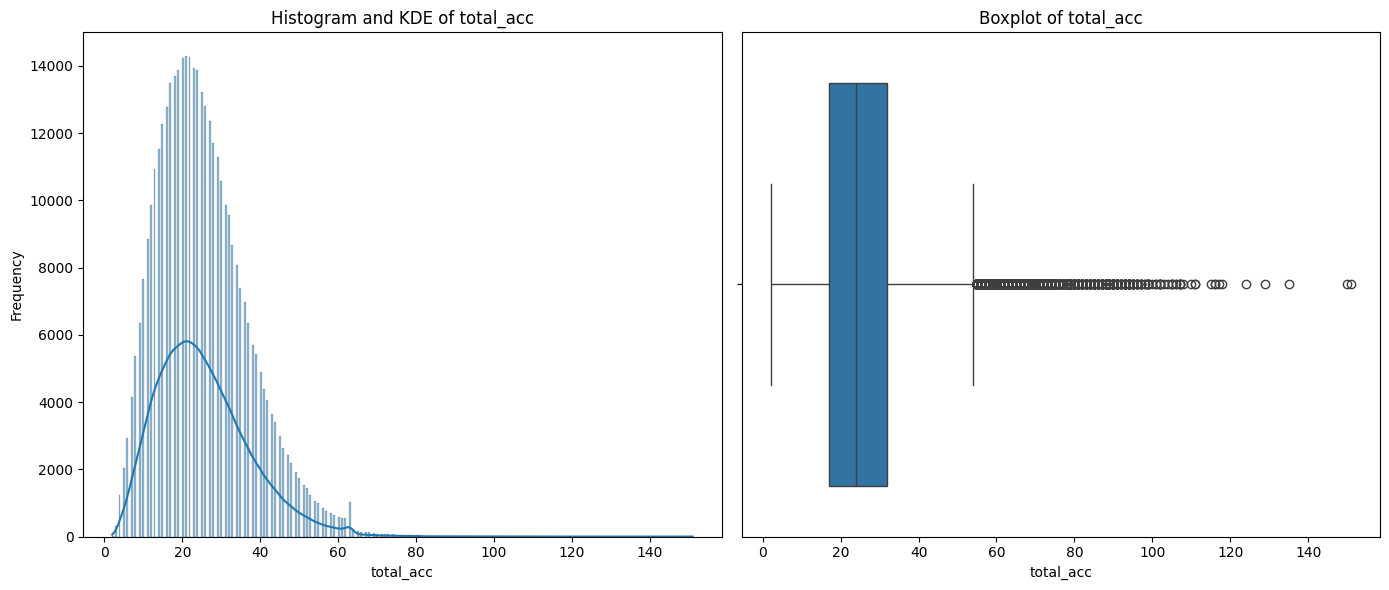


--------------------------------------------------
Analysis for Column: mort_acc
--------------------------------------------------
Skewness: 1.6001
Kurtosis: 4.4772

Top 10 value counts:
mort_acc
0.0    139777
1.0     60416
2.0     49948
3.0     38049
4.0     27887
5.0     18194
6.0     11069
7.0      6052
8.0      3121
9.0      1656
Name: count, dtype: int64

Bottom 10 value counts:
mort_acc
21.0    4
25.0    4
27.0    3
26.0    2
32.0    2
31.0    2
23.0    2
34.0    1
28.0    1
30.0    1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.844531
1    0.552164
2   -0.844531
3   -0.844531
4   -0.378966
5    1.017730
6    0.552164
7   -0.844531
8    0.552164
9   -0.378966
Name: mort_acc, dtype: float64


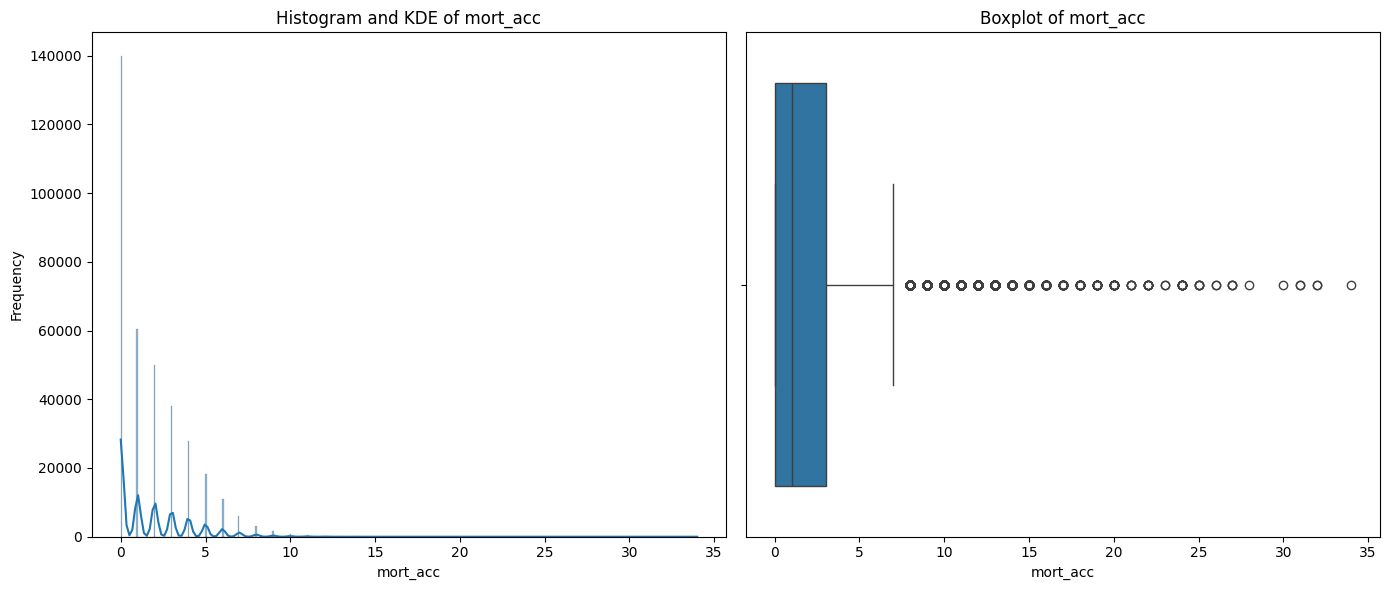


--------------------------------------------------
Analysis for Column: pub_rec_bankruptcies
--------------------------------------------------
Skewness: 3.4234
Kurtosis: 18.1042

Top 10 value counts:
pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64

Bottom 10 value counts:
pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.34154
1   -0.34154
2   -0.34154
3   -0.34154
4   -0.34154
5   -0.34154
6   -0.34154
7   -0.34154
8   -0.34154
9   -0.34154
Name: pub_rec_bankruptcies, dtype: float64


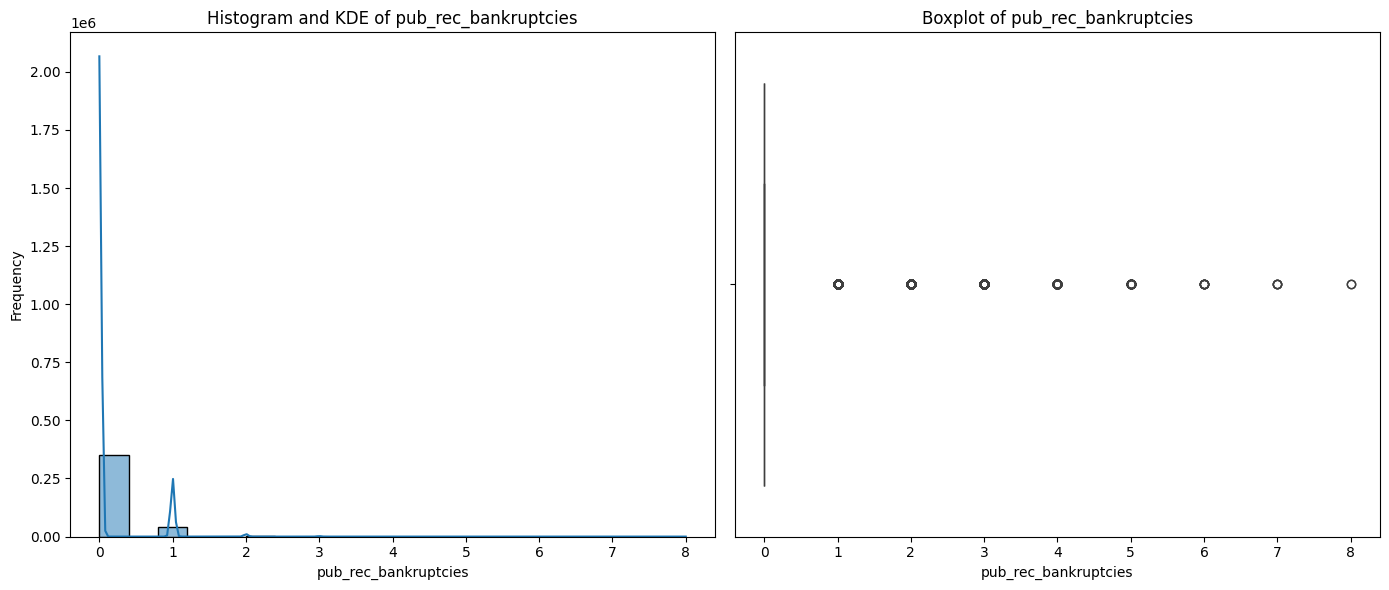


--------------------------------------------------
Analysis for Column: earliest_cr_line_month
--------------------------------------------------
Skewness: -0.1285
Kurtosis: -1.2020

Top 10 value counts:
earliest_cr_line_month
10    38291
9     37673
8     37349
11    35583
12    33687
7     31972
3     31617
1     30694
6     30445
5     30445
Name: count, dtype: int64

Bottom 10 value counts:
earliest_cr_line_month
8     37349
11    35583
12    33687
7     31972
3     31617
1     30694
6     30445
5     30445
4     29231
2     29043
Name: count, dtype: int64

Z-scores (First 10 values):
0   -0.220154
1    0.070966
2    0.362086
3    0.653207
4   -1.093515
5   -1.675755
6    0.362086
7    0.653207
8   -0.220154
9    1.526568
Name: earliest_cr_line_month, dtype: float64


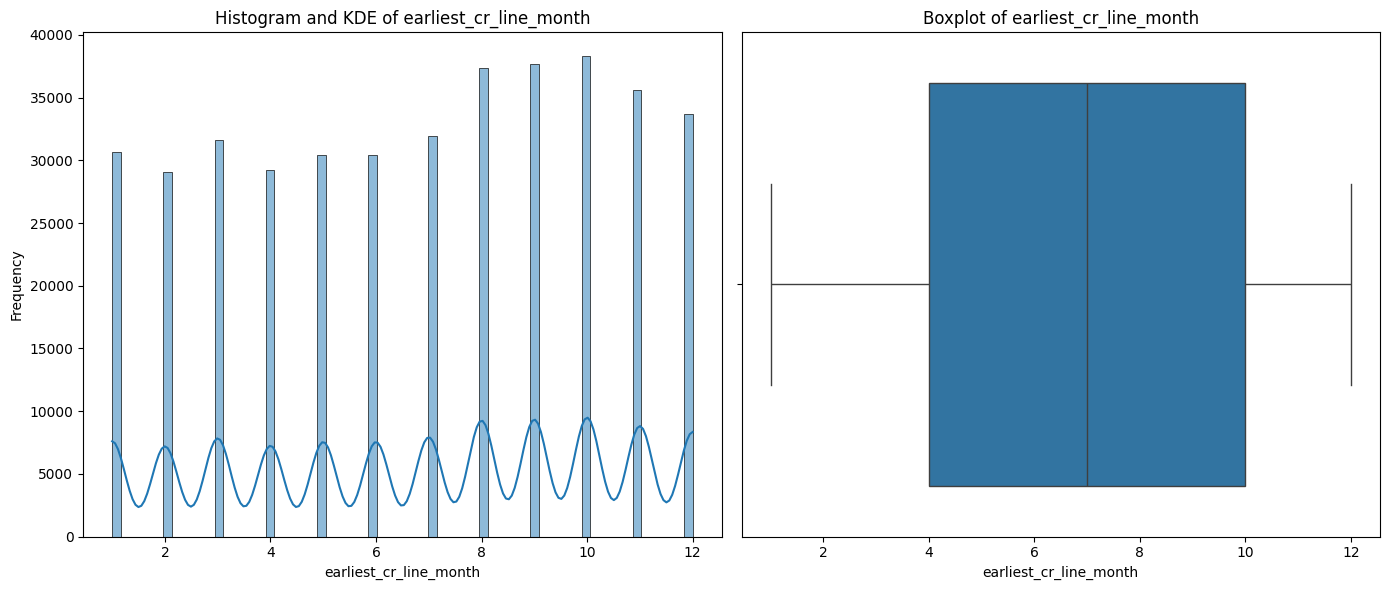


--------------------------------------------------
Analysis for Column: earliest_cr_line_year
--------------------------------------------------
Skewness: -1.0736
Kurtosis: 1.7421

Top 10 value counts:
earliest_cr_line_year
2000    29366
2001    29083
1999    26491
2002    25901
2003    23657
1998    22745
2004    20914
1997    18761
1996    18413
2005    17401
Name: count, dtype: int64

Bottom 10 value counts:
earliest_cr_line_year
1958    12
1955     9
1957     7
1956     7
1954     4
1950     3
1951     3
1953     2
1944     1
1948     1
Name: count, dtype: int64

Z-scores (First 10 values):
0   -1.091589
1    0.853294
2    1.270055
3    1.131134
4    0.158693
5    0.992214
6    0.992214
7   -0.535908
8   -0.535908
9   -0.119147
Name: earliest_cr_line_year, dtype: float64


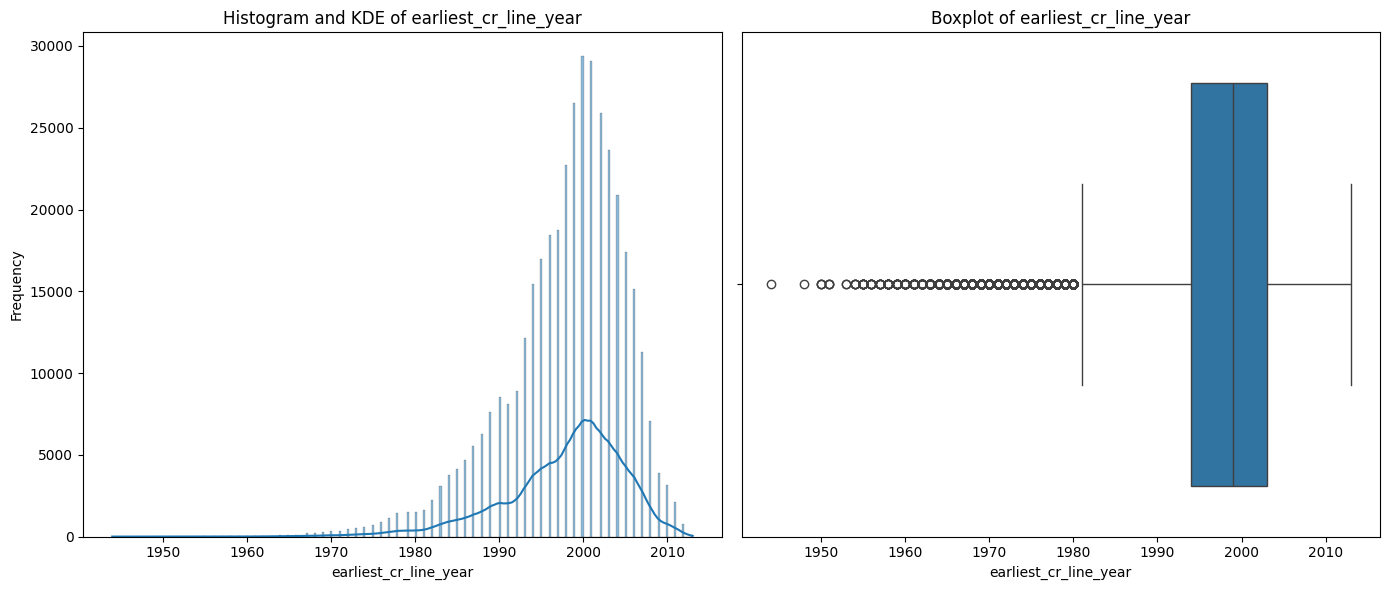

In [16]:
for i in df.select_dtypes(include=['number']).columns.tolist():
    print(f"\n{'-'*50}")
    print(f"Analysis for Column: {i}")
    print(f"{'-'*50}")

    skew_value = df[i].skew()
    print(f"Skewness: {skew_value:.4f}")

    kurt_value = df[i].kurt()
    print(f"Kurtosis: {kurt_value:.4f}")

    print("\nTop 10 value counts:")
    print(df[i].value_counts().head(10))

    print("\nBottom 10 value counts:")
    print(df[i].value_counts().tail(10))

    z_scores = zscore(df[i].dropna())
    print(f"\nZ-scores (First 10 values):")
    print(z_scores[:10])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(df[i], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram and KDE of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(x=df[i], ax=axes[1])
    axes[1].set_title(f'Boxplot of {i}')
    axes[1].set_xlabel(i)

    plt.tight_layout()
    plt.show()

#### Analysis and Insights (Numerical Columns)
- **Loan Amount (loan_amnt)**
    - Skewness: The data is positively skewed, meaning most loan amounts are towards the lower range (closer to the minimum).
    - Top Values: Loan amounts around 10,000 to 20,000 are the most common.
    - Outliers: A few loan amounts (like 36,525, 39,475) appear only once, indicating these are rare or erroneous entries.
    - Z-Scores: Most values fall within typical ranges, with some significant deviations indicating potential outliers.
- **Interest Rate (int_rate)**
    - Skewness: Slight positive skew, meaning there are more loans with lower interest rates.
    - Top Values: The most frequent interest rates are in the 10-16% range.
    - Outliers: A few unique high interest rates (such as 24.40%) indicate possible data anomalies.
    - Z-Scores: Most values are within a reasonable range, though a few exhibit large negative or positive deviations.
- **Installment Amount (installment)**
    - Skewness: Positive skew, meaning most installment values are lower.
    - Top Values: Common installment amounts range from 300 to 600.
    - Outliers: A few very high installment amounts (e.g., 1146.14) that may be errors or represent high-loan amounts with high-interest rates.
    - Z-Scores: Some values (e.g., 1.98) indicate extreme deviations that may require further investigation.
- **Annual Income (annual_inc)**
    - Skewness: Extremely high skewness, with most borrowers earning below average but some extreme high-income values.
    - Top Values: Common annual incomes are around 50,000 to 80,000.
    - Outliers: Many extreme high-income values (e.g., 745,000) are likely outliers or errors in data entry.
    - Z-Scores: Large variation, with significant deviations indicating possible data errors or outliers.
- **Debt-to-Income Ratio (dti)**
    - Skewness: Extremely high skewness, with most values clustered at the lower end (around 0-20%).
    - Top Values: Most common values are multiples of 1.2, such as 14.4, 16.8, etc.
    - Outliers: High DTI ratios (e.g., 45.15) indicate potential outliers.
    - Z-Scores: Indicates a few unusual values, suggesting potential data issues or outliers that require correction.
- **Number of Open Accounts (open_acc)**
    - Skewness: Slightly positive skew, indicating most individuals have around 9 to 14 open accounts.
    - Top Values: Common account numbers are between 5 and 14.
    - Outliers: Very few people have an unusually high number of open accounts (e.g., 90).
    - Z-Scores: Most values are within a reasonable range, with only a few extremes.
- **Public Records (pub_rec)**
    - Skewness: Highly skewed, as most individuals have no public records.
    - Top Values: 0 (no public records) is the most frequent value, with 1 and 2 being common as well.
    - Outliers: Some individuals have multiple public records, though these are rare.
    - Z-Scores: Most values are clustered around zero, but the distribution suggests many zeros and some rare high counts.
- **Revolving Balance (revol_bal)**
    - Skewness: Extremely positive skew, meaning most individuals have a small revolving balance.
    - Top Values: Many entries have a balance of 0, with others ranging from 5,000 to 10,000.
    - Outliers: Some high revolving balances (e.g., 568,659) are rare and likely indicate data errors or rare extreme cases.
    - Z-Scores: There are a few extreme outliers, suggesting potential errors or misreported data.
- **Revolving Utilization (revol_util)**
    - Skewness: Slight negative skew, with most revolving utilization ratios around 50%.
    - Top Values: Most common values are 53, 60, 61%, with some slightly deviating percentages (e.g., 37.63).
    - Outliers: A few extreme values (e.g., 146.1%) are likely errors or unusual cases.
    - Z-Scores: Indicates that most values fall within normal ranges, with a few extreme deviations.
- **Total Accounts (total_acc)**
    - Skewness: Slightly positive skew, with most individuals having between 17 and 26 total accounts.
    - Top Values: Most common account numbers are around 20 to 26.
    - Outliers: A few outliers with very high numbers of total accounts (e.g., 118, 151).
    - Z-Scores: There are some significant deviations from the mean, suggesting a few individuals have exceptionally high or low account counts.
- **Mortgage Accounts (mort_acc)**
    - Skewness: Positive skew, with most individuals having no mortgage accounts.
    - Top Values: Most frequent counts are 0, 1, and 2 mortgage accounts.
    - Outliers: Few individuals have more than 10 mortgage accounts, which might be rare or indicate special cases.
    - Z-Scores: Generally clustered around zero, with a few outliers indicating unusual mortgage patterns.
- **Public Record Bankruptcies (pub_rec_bankruptcies)**
    - Skewness: Highly skewed, with most individuals having no bankruptcies.
    - Top Values: Most common is 0 (no bankruptcies), followed by 1 bankruptcy.
    - Outliers: Few individuals have more than 1 bankruptcy, suggesting rare extreme cases.
    - Z-Scores: Most values are clustered near zero, indicating that most borrowers have no bankruptcies, with a few exceptions.
- **earliest_cr_line_month:**
    - Skewness: -0.1285 (Slightly left-skewed distribution, indicating the values are relatively balanced but slightly weighted towards earlier months.)
    - Kurtosis: -1.2020 (Platykurtic distribution, meaning the data is flatter and has lighter tails than a normal distribution.)
    - Top 10 Frequent Months: The most common months are October (38,291), September (37,673), and August (37,349). These months suggest seasonal trends in the earliest credit line dates, possibly due to financial cycles or borrower behaviors.
    - Bottom 10 Frequent Months: February (29,043) and April (29,231) are the least frequent months, indicating fewer credit lines originated during these periods.
    - Z-Scores: The first 10 z-scores indicate some variation around the mean, with values like 1.5266 showing above-average occurrences and -1.6757 showing below-average occurrences, highlighting moderate dispersion.
- **earliest_cr_line_year:**
    - Skewness: -1.0736 (The distribution is moderately left-skewed, meaning there are more recent years with earlier credit lines compared to older years.)
    - Kurtosis: 1.7421 (Leptokurtic distribution, indicating a higher peak and heavier tails than a normal distribution, suggesting a concentration of data around a central point with outliers at both ends.)
    - Top 10 Frequent Years: The most common years for earliest credit lines are from 2000 to 2003, with 2000 (29,366) and 2001 (29,083) being the most frequent. This suggests a concentration of credit lines issued around the early 2000s, possibly due to a financial boom or lending pattern during that period.
    - Bottom 10 Frequent Years: The least frequent years are from the 1950s, with 1958 (12), 1955 (9), and others having very few occurrences. This likely indicates a very small number of older credit lines from individuals whose financial activity was reported long after the initial credit establishment.
    - Z-Scores: The first 10 z-scores show moderate variations around the mean, with values like 1.2700 indicating years with higher occurrences and -1.0916 showing below-average frequencies for specific years. These variations suggest that while most data is concentrated in more recent years, some older years have relatively few data points.

## Bivariate Analysis

In [17]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,city,state,earliest_cr_line_month,earliest_cr_line_year
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,41.8,25.0,w,INDIVIDUAL,0.0,0.0,Mendozaberg,OK,6,1990
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,53.3,27.0,f,INDIVIDUAL,3.0,0.0,Loganmouth,SD,7,2004
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,92.2,26.0,f,INDIVIDUAL,0.0,0.0,New Sabrina,WV,8,2007
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,21.5,13.0,f,INDIVIDUAL,0.0,0.0,Delacruzside,MA,9,2006
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,69.8,43.0,f,INDIVIDUAL,1.0,0.0,Greggshire,VA,3,1999


In [18]:
df[df.select_dtypes(include=['object']).columns.tolist()].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,application_type,city,state
0,36 months,B,B4,Marketing,10+ years,RENT,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,w,INDIVIDUAL,Mendozaberg,OK
1,36 months,B,B5,Credit analyst,4 years,MORTGAGE,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,f,INDIVIDUAL,Loganmouth,SD
2,36 months,B,B3,Statistician,< 1 year,RENT,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,f,INDIVIDUAL,New Sabrina,WV
3,36 months,A,A2,Client Advocate,6 years,RENT,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,f,INDIVIDUAL,Delacruzside,MA
4,60 months,C,C5,Destiny Management Inc.,9 years,MORTGAGE,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,f,INDIVIDUAL,Greggshire,VA


In [19]:
print('Count of duplicated rows')
df[df.duplicated()]

Count of duplicated rows


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,city,state,earliest_cr_line_month,earliest_cr_line_year


In [20]:
print('Presence of null values in the dataset')
pd.DataFrame({
    'Null Count': df.isnull().sum(),
    'Null Percentage': round((df.isnull().sum() / df.shape[0]) * 100, 2)
})

Presence of null values in the dataset


,Null Count,Null Percentage
loan_amnt,0,0.00
term,0,0.00
int_rate,0,0.00
installment,0,0.00
grade,0,0.00
sub_grade,0,0.00
emp_title,22927,5.79
emp_length,18301,4.62
home_ownership,0,0.00
annual_inc,0,0.00
